In [1]:
from scipy.io import loadmat
import xarray as xr
import numpy as np

from datetime import datetime
import PyFVCOM as pf

# Load an FVCOM model output and plot a surface.
from PyFVCOM.read import FileReader
from PyFVCOM.plot import Plotter
from cmocean import cm
import matplotlib.pyplot as plt

invalid value encountered in cast (/opt/miniconda3/envs/pyfvcom/lib/python3.12/site-packages/utide/harmonics.py:16)
invalid value encountered in cast (/opt/miniconda3/envs/pyfvcom/lib/python3.12/site-packages/utide/harmonics.py:17)


In [2]:
# Load the .mat file
mat_data = loadmat('mobj_2005.mat')

In [3]:
# Explorar las claves del diccionario para ver qué variables están disponibles
print(mat_data.keys())

# Acceder a la variable 'Mobj'
Mobj = mat_data['Mobj']

# Ahora puedes acceder a los atributos dentro de Mobj. Si lonc está allí:
lonc = Mobj['lonc'][0][0]  # Esto puede variar según cómo esté almacenado
latc = Mobj['latc'][0][0]  # Esto puede variar según cómo esté almacenado

lon = Mobj['lon'][0][0]  # Esto puede variar según cómo esté almacenado
lat = Mobj['lat'][0][0]  # Esto puede variar según cómo esté almacenado

fvcom_lonlat = np.array((lon, lat))

dict_keys(['__header__', '__version__', '__globals__', 'Mobj'])


In [4]:
# Define a start, end and sampling interval for the tidal data
start = datetime.strptime('2005-06-30', '%Y-%m-%d')
end = datetime.strptime('2005-09-29', '%Y-%m-%d')
interval = 1 / 24  # 1 hourly in units of days
model = pf.preproc.Model(start, end, 'Golfo_v8_gridscope_fixedv6.2dm', sampling=interval,
                         native_coordinates='spherical', zone='20N')

In [5]:
ncfiles = 'Data3hr/2005*12.nc'

with xr.open_mfdataset(ncfiles, parallel=True,combine='nested', concat_dim="time", data_vars='minimal', \
                       coords='minimal', compat='override') as dsts:
    print("Creating xarray.Dataset from " + str(ncfiles))

dsts

Creating xarray.Dataset from Data3hr/2005*12.nc


<xarray.Dataset> Size: 303MB
Dimensions:   (time: 90, lat: 163, lon: 126, depth: 40)
Coordinates:
  * time      (time) datetime64[ns] 720B 2005-07-01T12:00:00 ... 2005-09-28T1...
  * lat       (lat) float64 1kB 19.04 19.12 19.2 19.28 ... 31.84 31.92 32.0
  * lon       (lon) float64 1kB -115.0 -115.0 -114.9 ... -105.2 -105.1 -105.0
  * depth     (depth) float64 320B 0.0 2.0 4.0 6.0 ... 2.5e+03 3e+03 4e+03 5e+03
Data variables:
    surf_el   (time, lat, lon) float32 7MB dask.array<chunksize=(1, 163, 126), meta=np.ndarray>
    salinity  (time, depth, lat, lon) float32 296MB dask.array<chunksize=(1, 6, 163, 126), meta=np.ndarray>
Attributes: (12/14)
    classification_level:      UNCLASSIFIED
    distribution_statement:    Approved for public release. Distribution unli...
    downgrade_date:            not applicable
    classification_authority:  not applicable
    institution:               Naval Oceanographic Office
    source:                    HYCOM archive file
    ...                        ...
    Conventions:               CF-1.6 NAVO_netcdf_v1.1
    History:                   Translated to CF-1.0 Conventions by Netcdf-Jav...
    geospatial_lat_min:        19.040000915527344
    geospatial_lat_max:        32.0
    geospatial_lon_min:        -115.03997802734375
    geospatial_lon_max:        -105.03997802734375

In [8]:
ssh_values = dsts['surf_el'].values
sss_values = dsts['salinity'][:,0,:,:].values
ssh_lon = dsts['lon'].values
ssh_lat = dsts['lat'].values
hycom_times = dsts['time'].values

np.shape(ssh_values), np.shape(sss_values), len(ssh_lat)

((90, 163, 126), (90, 163, 126), 163)

In [25]:
ft = pf.preproc.RegularGridInterpolator((ssh_lon, ssh_lat), ssh_values.T, method='linear', fill_value=None)
interp_ssh = ft(fvcom_lonlat.T)

interp_ssh = np.squeeze(interp_ssh)

In [26]:
fvcom_lonlat = np.squeeze(fvcom_lonlat)

In [27]:
# Contar el número total de NaN en interp_ssh
num_nans = np.isnan(interp_ssh).sum()
print(f"El número de NaN en interp_ssh es: {num_nans}")

El número de NaN en interp_ssh es: 172800


In [28]:
from scipy.interpolate import griddata

# Verificar si existen NaN y rellenarlos
for t in range(interp_ssh.shape[1]):  # Iterar sobre cada tiempo
    # Crear una máscara para los valores NaN en el tiempo `t`
    mask = np.isnan(interp_ssh[:, t])
    
    if np.any(mask):
        # Usar solo los nodos válidos para interpolación
        interp_ssh[mask, t] = griddata(
            fvcom_lonlat.T[~mask],           # Coordenadas de nodos sin NaN
            interp_ssh[~mask, t],          # Valores en esos nodos
            fvcom_lonlat.T[mask],            # Coordenadas de nodos con NaN
            method='nearest'               # Método de interpolación
        )

In [29]:
# Contar el número total de NaN en interp_ssh
num_nans = np.isnan(interp_ssh).sum()
print(f"El número de NaN en interp_ssh es: {num_nans}")

El número de NaN en interp_ssh es: 0


In [34]:
model.time.Times[-1]

'2005-09-29T00:00:00.000000'

In [35]:
# Crear un nuevo array con fechas cada 3 elementos, comenzando desde el índice 17
Times_cada_3 = model.time.Times[29:-8:24]
time_cada_3 = model.time.time[29:-8:24]
Itime_cada_3 = model.time.Itime[29:-8:24]
Itime2_cada_3 = model.time.Itime2[29:-8:24]

Times_cada_3

['2005-07-01T12:00:00.000000',
 '2005-07-02T12:00:00.000000',
 '2005-07-03T12:00:00.000000',
 '2005-07-04T12:00:00.000000',
 '2005-07-05T12:00:00.000000',
 '2005-07-06T12:00:00.000000',
 '2005-07-07T12:00:00.000000',
 '2005-07-08T12:00:00.000000',
 '2005-07-09T12:00:00.000000',
 '2005-07-10T12:00:00.000000',
 '2005-07-11T12:00:00.000000',
 '2005-07-12T12:00:00.000000',
 '2005-07-13T12:00:00.000000',
 '2005-07-14T12:00:00.000000',
 '2005-07-15T12:00:00.000000',
 '2005-07-16T12:00:00.000000',
 '2005-07-17T12:00:00.000000',
 '2005-07-18T12:00:00.000000',
 '2005-07-19T12:00:00.000000',
 '2005-07-20T12:00:00.000000',
 '2005-07-21T12:00:00.000000',
 '2005-07-22T12:00:00.000000',
 '2005-07-23T12:00:00.000000',
 '2005-07-24T12:00:00.000000',
 '2005-07-25T12:00:00.000000',
 '2005-07-26T12:00:00.000000',
 '2005-07-27T12:00:00.000000',
 '2005-07-28T12:00:00.000000',
 '2005-07-29T12:00:00.000000',
 '2005-07-30T12:00:00.000000',
 '2005-07-31T12:00:00.000000',
 '2005-08-01T12:00:00.000000',
 '2005-0

In [36]:
lons = np.squeeze(lon)
lats = np.squeeze(lat)

# Desanidar el array para obtener el valor numérico
nodes = Mobj['nVerts'][0].item()

# Si necesitas aplanarlo aún más, usa flatten()
nodes = nodes.flatten()

In [37]:
# Convertir al nuevo formato
tiempos_convertidos = [
    datetime.strptime(t, "%Y-%m-%dT%H:%M:%S.%f").strftime("%Y/%m/%d %H:%M:%S.%f")
    for t in Times_cada_3
]

tiempos_convertidos

['2005/07/01 12:00:00.000000',
 '2005/07/02 12:00:00.000000',
 '2005/07/03 12:00:00.000000',
 '2005/07/04 12:00:00.000000',
 '2005/07/05 12:00:00.000000',
 '2005/07/06 12:00:00.000000',
 '2005/07/07 12:00:00.000000',
 '2005/07/08 12:00:00.000000',
 '2005/07/09 12:00:00.000000',
 '2005/07/10 12:00:00.000000',
 '2005/07/11 12:00:00.000000',
 '2005/07/12 12:00:00.000000',
 '2005/07/13 12:00:00.000000',
 '2005/07/14 12:00:00.000000',
 '2005/07/15 12:00:00.000000',
 '2005/07/16 12:00:00.000000',
 '2005/07/17 12:00:00.000000',
 '2005/07/18 12:00:00.000000',
 '2005/07/19 12:00:00.000000',
 '2005/07/20 12:00:00.000000',
 '2005/07/21 12:00:00.000000',
 '2005/07/22 12:00:00.000000',
 '2005/07/23 12:00:00.000000',
 '2005/07/24 12:00:00.000000',
 '2005/07/25 12:00:00.000000',
 '2005/07/26 12:00:00.000000',
 '2005/07/27 12:00:00.000000',
 '2005/07/28 12:00:00.000000',
 '2005/07/29 12:00:00.000000',
 '2005/07/30 12:00:00.000000',
 '2005/07/31 12:00:00.000000',
 '2005/08/01 12:00:00.000000',
 '2005/0

In [38]:
import numpy as np
from netCDF4 import Dataset

# Datos de ejemplo
node = 5734  # Número de nodos
nt = min(len(time_cada_3), len(Itime_cada_3), len(Itime2_cada_3), len(Times_cada_3), interp_ssh.shape[1])

# Crear el archivo NetCDF
ncid = Dataset('2005_sshgrd.nc', 'w', format='NETCDF4')

# Definir las dimensiones
node_dimid = ncid.createDimension('node', node)
time_dimid = ncid.createDimension('time', None)  # Dimensión ilimitada para el tiempo
DateStrLen_dimid = ncid.createDimension('DateStrLen', 26)

# Definir lon y lat (no tienen la dimensión 'time')
lon_varid = ncid.createVariable('lon', 'f4', ('node',))
lon_varid.long_name = 'nodal longitude'
lon_varid.units = 'degrees_east'
    
lat_varid = ncid.createVariable('lat', 'f4', ('node',))
lat_varid.long_name = 'nodal latitude'
lat_varid.units = 'degrees_north'

# Definir el tiempo y las variables relacionadas (manteniendo 'time' como última dimensión)
time_varid = ncid.createVariable('time', 'f4', ('time',))
time_varid.long_name = 'time'
time_varid.units = 'days since 1858-11-17 00:00:00'
time_varid.format = 'modified julian day (MJD)'
time_varid.time_zone = 'UTC'

Itime_varid = ncid.createVariable('Itime', 'i4', ('time',))
Itime_varid.units = 'days since 1858-11-17 00:00:00'
Itime_varid.format = 'modified julian day (MJD)'
Itime_varid.time_zone = 'UTC'

Itime2_varid = ncid.createVariable('Itime2', 'i4', ('time',))
Itime2_varid.units = 'msec since 00:00:00'
Itime2_varid.time_zone = 'UTC'

Times_varid = ncid.createVariable('Times', 'S1', ('time', 'DateStrLen'))
Times_varid.time_zone = 'UTC'

# Definir la altura de la superficie del mar (SSH) con 'time' al final
ssh_varid = ncid.createVariable('ssh', 'f4', ('time', 'node'))
ssh_varid.long_name = 'Water Surface Height'
ssh_varid.units = 'meters'


# Atributos globales
ncid.source = 'FVCOM grid (unstructured) surface forcing'

# Escribir los datos en las variables
ncid.variables['lon'][:] = lons
ncid.variables['lat'][:] = lats

# Escribir los datos en las variables usando el bucle corregido
for it in range(nt):
    ncid.variables['time'][it] = time_cada_3[it]
    ncid.variables['Itime'][it] = Itime_cada_3[it]
    ncid.variables['Itime2'][it] = Itime2_cada_3[it]
    
    # Usar sólo un índice para Times_cada_3 ya convertido en array de NumPy
    ncid.variables['Times'][it, :] = list(tiempos_convertidos[it])  
    ncid.variables['ssh'][it, :] = interp_ssh[:, it].T 

# Cerrar el archivo NetCDF
ncid.close()

In [31]:
# Create an object which holds the model outputs. We're only loading
# surface elevation and temperature for the first 200 time steps.
fvcom = FileReader('1year_fixed_8c_gs_2005_0001.nc',  variables=['zeta', 'temp'])

Text(0.5, 1.0, '2005-09-28T12:00:00.000000000')

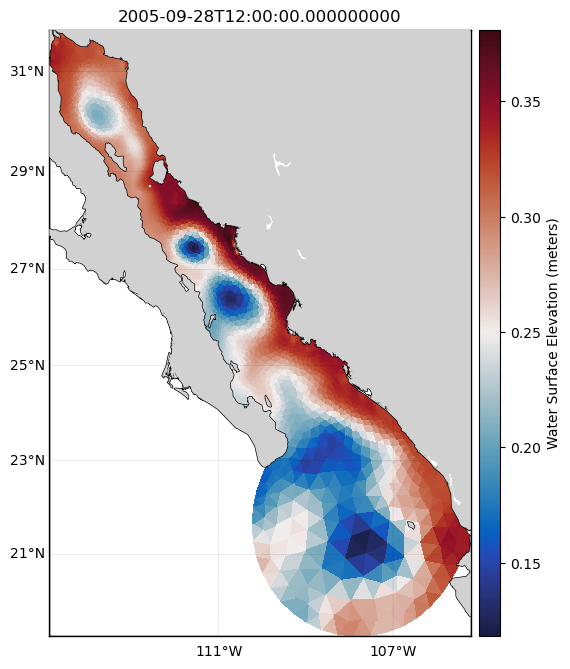

In [33]:
# Make a plot of the surface elevation.
plot = Plotter(fvcom,
               figsize=(20, 20),
               res='i',
               tick_inc=(4, 2),
               cb_label='{} ({})'.format(fvcom.atts.zeta.long_name,
                                         fvcom.atts.zeta.units),
               cmap=cm.balance)
plot.plot_field(interp_ssh[:, 10])
plot.axes.set_title(hycom_times[-1])

